# hyperparameterTunningResults6
Andrew E. Davidson  
aedavids@ucsc.edu  
5/20/2024

Copyright (c) 2020-2023, Regents of the University of California All rights reserved. https://polyformproject.org/licenses/noncommercial/1.0.0

ref: 
- deconvolutionAnalysis/doc/addDegree2Genes.md
- deconvolutionAnalysis/doc/bestCuratedNotes.md
- intraExtraRNA_POC/adenocarcinoma.vs.control/enrichESCA.ipynb
- deconvolutionAnalysis/jupyterNotebooks/hyperParameterTunning/findCandidateEnrichmentBiomarkers.ipynb

**overview**  
See if we can improve both deconvolution hyperparameter results from dec 2023 - jan 24, and elife random forest hyperparater results

**What are we optimizing? What should our evaluation metric be?**  
Before 5/30/24 we used on mean Specificity and Sensitivity to evaluate the deconvolution results for a given signature matrix. In general there is not much difference in the means or medians between different runs. Small changes and ??re-runs?? produce different results. I.E. the classes above and bellow a given thrshold varry. 

The gene select algorithm is complete determinstic. 

I think the isssue is the deconvolution is over determined. The number of genes is greater than the number of class. This means we have more equations than unknowns. over determined systems have the following implications

1. No Solution: Generally, an overdetermined system may have no solutions because it is unlikely that all the equations can be satisfied simultaneously. The equations might be inconsistent with each other.

2. Least Squares Solution: If an exact solution is not possible, one common approach is to find an approximate solution that minimizes the sum of the squares of the residuals (the differences between the left and right sides of the equations). This method is known as the least squares solution.

3. Rank and Consistency: The system is consistent (has at least one solution) if the rank of the coefficient matrix 
A is equal to the rank of the augmented matrix.  If the rank is less than the number of unknowns n, the system may have infinitely many solutions.

CIBERSORTx is using some form of Least Squares Solution. I think inconsistcy is becuase we can not set the random seed number

**A better metric might be looking at the percent of classes above a given threshold.** we use precent instead of number above becuase "lumping" reduces the number of classes.
In the example bellow notice the 
there is a large difference in percent of classes above the threshold, however small difference in mean and median

```
metric : sensitivity threshold: 0.9
                              mean     median numAboveThreshold percentAboveThreshold
best10CuratedDegree1_ce467ff  0.808831 0.871  36                0.46
best10CuratedDegree1LumpBrain 0.820169 0.864  27                0.38
```

**<span style="color:red;background-color:yellow">TODO</span>**  
1. rework the lump conclusion counting NaN is misleading
    Is lumping a good strategy?
   
3. create version of findUnderPerformaingClasses that display classes >= threshold.
   can we pick and choose the signatue from different runs?
   
5. review symteric classification errors  
    can we find classes that we should lump? Search for symetricRowSort()

6. confirm best10CuratedDegree1_ce467ff  assending=True is reproducable.
   - if it works we should try using it as a base, ie lump, ...
   - add parameter to config() class
   - <span style="color:red">mean, median sensitivity is close.</span> difference could be because the system is overdetermined and we can not control random seed?

7. validate deconvolution with out setting random see produces different results

**<span style="color:red;background-color:yellow">best10CuratedDegree1_ce467ff bug</span>**  
sorted results in ascending order!

## 5/30/24

**should we lump all brain types? for just some** 
```
best10CuratedDegree1 brain classification error
- grep brain 1484 error
- 663 are a mis classification between 13 brain type
- TODO 
  * how man errors are of type  (a,b) (b,a) error
  * before we do a lot of work what is the sensitivity of these classes?

test code hyper6.ipynb
errorMetricPath = "/private/groups/kimlab/aedavids/deconvolution/1vsAll-~gender_category/best10CuratedDegree1_ce467ff/training/best10CuratedDegree1.sh.out/metrics/classificationErrors.csv"

only has a total of 279 (a,b) (b,a) error

trueCat	predCat	errorCount_x	sortKey	errorCount_y
82	Brain_Nucleus_accumbens_basal_ganglia	Brain_Caudate_basal_ganglia	10	4501301964017204649	55
83	Brain_Caudate_basal_ganglia	Brain_Nucleus_accumbens_basal_ganglia	45	4501301964017204649	55

50	Brain_Putamen_basal_ganglia	Brain_Caudate_basal_ganglia	27	-391772064955491717	41
51	Brain_Caudate_basal_ganglia	Brain_Putamen_basal_ganglia	14	-391772064955491717	41

42	Brain_Frontal_Cortex_BA9	Brain_Anterior_cingulate_cortex_BA24	3	-1183847672473850142	38
43	Brain_Anterior_cingulate_cortex_BA24	Brain_Frontal_Cortex_BA9	35	-1183847672473850142	38

24	Brain_Anterior_cingulate_cortex_BA24	Brain_Amygdala	4	-4085206653109838864	31
25	Brain_Amygdala	Brain_Anterior_cingulate_cortex_BA24	27	-4085206653109838864	31

14	Brain_Putamen_basal_ganglia	Brain_Nucleus_accumbens_basal_ganglia	25	-6021895247826768161	27
15	Brain_Nucleus_accumbens_basal_ganglia	Brain_Putamen_basal_ganglia	2	-6021895247826768161	27

30	Brain_Cerebellum	Brain_Cerebellar_Hemisphere	9	-3703135087296370628	26
31	Brain_Cerebellar_Hemisphere	Brain_Cerebellum	17	-3703135087296370628	26

60	Brain_Frontal_Cortex_BA9	Brain_Cortex	16	926165062072705662	22
61	Brain_Cortex	Brain_Frontal_Cortex_BA9	6	926165062072705662	22

12	Brain_Substantia_nigra	Brain_Hypothalamus	7	-6368628056941588537	11
13	Brain_Hypothalamus	Brain_Substantia_nigra	4	-6368628056941588537	11

102	Brain_Hippocampus	Brain_Amygdala	2	7760850930368393976	10
103	Brain_Amygdala	Brain_Hippocampus	8	7760850930368393976	10

64	Brain_Amygdala	Brain_Frontal_Cortex_BA9	5	1253210174266395551	8
65	Brain_Frontal_Cortex_BA9	Brain_Amygdala	3	1253210174266395551	8

66	Brain_Hypothalamus	Brain_Nucleus_accumbens_basal_ganglia	3	1308236627886173898	6
67	Brain_Nucleus_accumbens_basal_ganglia	Brain_Hypothalamus	3	1308236627886173898	6

16	Brain_Cortex	Brain_Amygdala	1	-5254430581835602874	4
17	Brain_Amygdala	Brain_Cortex	3	-5254430581835602874	4
```

## 5/28 added LumpBrain results
- best10CuratedDegree1LumpBrain
- best500LumpBrainFindAllDegree1_wl500
- best500GTEx_TCGALumpBrain

Lumping brain the 13 brain types into a single brain category improve over all performance brain sensitivity. 
It does not improve over all performance. The number of class above 0.9 sensitivity drops

```
sensitivity                             Brain
best10CuratedDegree1LumpBrain           0.987
best10CuratedDegree1LumpBrainMedian     0.992
```

```
# sensitivity classes above threshold : 0.9 
# number of classes above threshold
best10CuratedDegree1_ce467ff           28
best10CuratedDegree1                   22
best10CuratedDegree1LumpBrain          31
```

```
average sensitivity:
best10CuratedDegree1_ce467ff	0.808831
best10CuratedDegree1	        0.786482
best10CuratedDegree1LumpBrain   0.820169
```

evidence creating gene signature using median instead of mean should preform better
```
median sensitivity
best10CuratedDegree1_ce467ff	0.871
best10CuratedDegree1	        0.833
best10CuratedDegree1LumpBrain	0.864	
```


## 5/29 best10CuratedDegree1LumpBrainMedian

In [1]:
import ipynbname

# use display() to print an html version of a data frame
# useful if dataFrame output is not generated by last like of cell
from IPython.display import display

import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
# display all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import pathlib as pl
import pprint as pp
import os
import seaborn as sns
import sys

/data/tmp/ipykernel_3022054/2859378696.py:9: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# setting the python path allows us to run python scripts from using
# the CLI. 
PYTHONPATH = os.environ['PYTHONPATH']
print("ORIG_PYTHONPATH: {}\n".format(PYTHONPATH))

gitRepoRoot = !git rev-parse --show-toplevel
gitRepoRoot = gitRepoRoot[0]

#
# add deconvolutionAnalysis modules
#
deconvolutionModules = f'{gitRepoRoot}/deconvolutionAnalysis/python'
print("deconvolutionModules: {}\n".format(deconvolutionModules))

PYTHONPATH = PYTHONPATH + f':{deconvolutionModules}'
#print("PYTHONPATH: {}\n".format(PYTHONPATH))

sys.path.append( str(deconvolutionModules) )
#print("\nsys.path:\n{}\n".format(sys.path))

#
# add intraExtraRNA_POC modules
#
intraExtraRNA_POCModules = f'{gitRepoRoot}/intraExtraRNA_POC/python/src'
print("intraExtraRNA_POCModules: {}\n".format(intraExtraRNA_POCModules))

PYTHONPATH = PYTHONPATH + f':{intraExtraRNA_POCModules}'
#print("PYTHONPATH: {}\n".format(PYTHONPATH))

sys.path.append( str(intraExtraRNA_POCModules) )
#print("\nsys.path:\n{}\n".format(sys.path))

ORIG_PYTHONPATH: :/private/home/aedavids/extraCellularRNA/src

deconvolutionModules: /private/home/aedavids/extraCellularRNA/deconvolutionAnalysis/python

intraExtraRNA_POCModules: /private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/python/src



In [3]:
from analysis.hyperParameterTunningMetrics import metricsRunner, elifeCols, lungCols
from analysis.hyperParameterTunningMetrics import findSummaryMetricsCols
from analysis.hyperParameterTunningMetrics import symetricRowSort
from analysis.utilities import findAllCategories, findAllGenes
from analysis.utilities import findIntersectionsWithDegree
from analysis.utilities import loadDictionary

from pipeline.dataFactory.utilities import urlify

In [4]:
root = "/private/groups/kimlab/aedavids/deconvolution/1vsAll-~gender_category"
notebookName = ipynbname.name()
outDir = f'{root}/hyperParameter/{notebookName}.out'
print( f'output dir: \n{outDir}' )
os.makedirs(outDir, exist_ok=True)

imgOut = f'{outDir}/img'
os.makedirs(imgOut, exist_ok=True)
print(f'\nimgOut :\n{imgOut}')

output dir: 
/private/groups/kimlab/aedavids/deconvolution/1vsAll-~gender_category/hyperParameter/hyperparameterTunningResults6.out

imgOut :
/private/groups/kimlab/aedavids/deconvolution/1vsAll-~gender_category/hyperParameter/hyperparameterTunningResults6.out/img


In [5]:
def evaluateDeconvolution(
    root: str,
    outDir: str,    
    resultsDirs : list[str],
    outFilePrefix : str,
    metric : str,
    #stageName : str, #  stageName is part of the outputfile prefix
    threshold : float,
    verbose : bool = False,
    ) -> tuple[pd.DataFrame, pd.DataFrame] :
    '''
    display(df.loc[:, findSummaryMetricsCols(metric) + elifeCols  ] )
    
    returns:
        df : 
            returns a row for each run in resultsDirs 
            The row contains the "metric" for each class + summary statistic

        bellowThresholdDF:
            example:
                    stage	        category	               value
                id			
                0	best10GTEx_TCGA	ACC	                        True
                2	best10GTEx_TCGA	Adipose_Visceral_Omentum	True
                5	best10GTEx_TCGA	Artery_Coronary	            True
                7	best10GTEx_TCGA	BLCA	                    True
                8	best10GTEx_TCGA	BRCA	                    True
            
    '''

    retDF, retBellowThresholdDF = metricsRunner(root, outDir, outFilePrefix, resultsDirs, 
                           metric=metric, threshold=threshold, verbose=verbose)

    display( retDF.loc[:, findSummaryMetricsCols(metric) + elifeCols  ] )

    # print(f'\n{stageName} classs < {threshold} {metric}')
    # selectRowsBellow = retBellowThresholdDF.loc[:, "stage"] == stageName
    
    # display( retBellowThresholdDF.loc[selectRowsBellow, 'category'] )

    return (retDF, retBellowThresholdDF)

In [6]:
def evaluateBest10CuratedDegree1(
        threshold : float = 0.7,
        metric : str = 'sensitivity',
        verbose : bool = False):
    '''
    TODO
    '''
    bestBes10ResultsDirs = [    
        'best1CuratedDegree1',
        'best2CuratedDegree1',
        'best3CuratedDegree1',
        'best5CuratedDegree1',
        "best10CuratedDegree1_ce467ff",        
        "best10CuratedDegree1Ascending", # Ascending performance should match ce467ff
        "best10CuratedDegree1",
        "best10CuratedDegree1LumpBrain",
        "best10CuratedDegree1LumpBrainMedian",
        "best10CuratedDegree1.degree1ESCA_01",
    ]
    
    print(f'metric : {metric} threshold: {threshold}')
    #stageName = "AEDWIP"
    outFilePrefix =  "best10CuratedDegree1Runs" 
    best10DF, bestBellowThresholdDF = evaluateDeconvolution(
                                            root=root,
                                            outDir=outDir,
                                            resultsDirs=bestBes10ResultsDirs, 
                                            outFilePrefix=outFilePrefix,
                                            metric=metric,
                                            #stageName=stageName,
                                            threshold=threshold,
                                            verbose=verbose,
                                            )
    
    return(best10DF, bestBellowThresholdDF)

## Best 10 CuratedDegree1 Specificity

In [7]:
# print(evalBest10CuratedDegree1SpecificityDF.shape)
# evalBest10CuratedDegree1SpecificityDF.head()

In [8]:
evaluateBest10CuratedDegree1SpecificityThreshold = 0.96
evaluateBest10CuratedDegree1SpecificityMetric = "specificity"
evalBest10CuratedDegree1SpecificityDF, evalBest10CuratedDegree1SpecificityBellowThresholdDF = \
    evaluateBest10CuratedDegree1(threshold=evaluateBest10CuratedDegree1SpecificityThreshold, 
                                 metric=evaluateBest10CuratedDegree1SpecificityMetric, verbose=True)

metric : specificity threshold: 0.96
path : /private/groups/kimlab/aedavids/deconvolution/1vsAll-~gender_category/best1CuratedDegree1

load best1CuratedDegree1 :
/private/groups/kimlab/aedavids/deconvolution/1vsAll-~gender_category/best1CuratedDegree1/training/best1CuratedDegree1.sh.out/metrics/metricsRounded.csv

load
/private/groups/kimlab/aedavids/deconvolution/1vsAll-~gender_category/best1CuratedDegree1/training/best1CuratedDegree1.sh.out/upsetPlot.out/best1_from_best500FindAllDegree1_wl500.intersection.dict

best1CuratedDegree1 types without degree 1 intersections: 
 set()
path : /private/groups/kimlab/aedavids/deconvolution/1vsAll-~gender_category/best2CuratedDegree1

load best2CuratedDegree1 :
/private/groups/kimlab/aedavids/deconvolution/1vsAll-~gender_category/best2CuratedDegree1/training/best2CuratedDegree1.sh.out/metrics/metricsRounded.csv

load
/private/groups/kimlab/aedavids/deconvolution/1vsAll-~gender_category/best2CuratedDegree1/training/best2CuratedDegree1.sh.out/upset

id,mean_specificity,std_specificity,median_specificity,numGenes,numTypes,numDegree1,numAboveThreshold,percentAboveThreshold,LUAD,LUSC,COAD,READ,ESCA,LIHC,STAD,Whole_Blood
best1CuratedDegree1,0.994181,0.009109,0.999,83,83,83,82,0.987952,0.999,0.997,0.999,0.994,0.987,0.989,0.998,0.999
best2CuratedDegree1,0.995880,0.006005,0.998,161,83,83,83,1.000000,0.991,0.996,0.998,0.995,0.994,0.991,0.999,1.000
best3CuratedDegree1,0.996398,0.004783,0.998,236,83,83,83,1.000000,0.997,0.995,0.997,0.993,0.997,0.992,0.999,1.000
best5CuratedDegree1,0.997000,0.004006,0.998,380,83,83,83,1.000000,0.999,0.996,0.996,0.995,0.998,0.994,1.000,1.000
best10CuratedDegree1_ce467ff,0.997855,0.002922,0.999,716,83,83,83,1.000000,0.998,0.995,0.995,0.996,0.999,1.000,0.999,0.999
best10CuratedDegree1Ascending,0.997699,0.003529,0.999,706,83,82,83,1.000000,0.999,0.996,0.981,0.994,1.000,1.000,1.000,0.999
best10CuratedDegree1,0.997542,0.003030,0.998,716,83,83,83,1.000000,1.000,0.994,0.993,0.991,0.998,0.999,1.000,1.000
best10CuratedDegree1LumpBrain,0.997690,0.002926,0.999,640,71,70,71,1.000000,1.000,0.995,0.991,0.994,0.998,0.998,1.000,1.000
best10CuratedDegree1LumpBrainMedian,0.997901,0.002636,0.999,640,71,70,71,1.000000,0.997,0.995,0.992,0.991,0.999,0.998,0.999,1.000
best10CuratedDegree1.degree1ESCA_01,0.996759,0.005057,0.998,713,83,83,83,1.000000,1.000,0.995,0.997,0.997,0.999,0.999,1.000,1.000


In [9]:
print(evalBest10CuratedDegree1SpecificityBellowThresholdDF.shape)
evalBest10CuratedDegree1SpecificityBellowThresholdDF

(1, 3)


,stage,category,value
id,,,
45,best1CuratedDegree1,LGG,True


## Best 10 CuratedDegree1 Sensitivity

In [10]:
# evaluateBest10CuratedDegree1Metric = 'sensitivity'
# evaluateBest10CuratedDegree1SensitivityThreshold = 0.70
# t =  evaluateBest10CuratedDegree1(
                                    # threshold=evaluateBest10CuratedDegree1Threshold, 
                                    # metric=evaluateBest10CuratedDegree1Metric)
#  evalBest10CuratedDegree1SensitivityDF, evalBest10CuratedDegree1SensitivityBellowThresholdDF = t

evaluateBest10CuratedDegree1SensitivityMetric = 'sensitivity'
evaluateBest10CuratedDegree1SensitivityThreshold = 0.90
t =  evaluateBest10CuratedDegree1(
        threshold=evaluateBest10CuratedDegree1SensitivityThreshold,
        metric=evaluateBest10CuratedDegree1SensitivityMetric)

evalBest10CuratedDegree1SensitivityDF, evalBest10CuratedDegree1SensitivityBellowThresholdDF  = t

metric : sensitivity threshold: 0.9

saving : /private/groups/kimlab/aedavids/deconvolution/1vsAll-~gender_category/hyperParameter/hyperparameterTunningResults6.out/best10CuratedDegree1Runs.sensitivity.0.9.csv

saving : /private/groups/kimlab/aedavids/deconvolution/1vsAll-~gender_category/hyperParameter/hyperparameterTunningResults6.out/best10CuratedDegree1Runs.sensitivity.bellow.0.9.csv


id,mean_sensitivity,std_sensitivity,median_sensitivity,numGenes,numTypes,numDegree1,numAboveThreshold,percentAboveThreshold,LUAD,LUSC,COAD,READ,ESCA,LIHC,STAD,Whole_Blood
best1CuratedDegree1,0.486398,0.359127,0.484,83,83,83,15,0.180723,0.246,0.203,0.304,0.607,0.486,0.789,0.431,0.989
best2CuratedDegree1,0.621855,0.310492,0.716,161,83,83,17,0.204819,0.146,0.296,0.411,0.589,0.486,0.807,0.280,0.989
best3CuratedDegree1,0.668783,0.304236,0.792,236,83,83,23,0.277108,0.172,0.359,0.424,0.607,0.423,0.839,0.293,0.985
best5CuratedDegree1,0.720494,0.258503,0.804,380,83,83,25,0.301205,0.220,0.488,0.614,0.625,0.441,0.888,0.267,0.982
best10CuratedDegree1_ce467ff,0.808831,0.202235,0.871,716,83,83,36,0.433735,0.841,0.691,0.652,0.607,0.369,0.874,0.409,1.000
best10CuratedDegree1Ascending,0.803410,0.194048,0.840,706,83,82,31,0.373494,0.751,0.628,0.684,0.518,0.162,0.767,0.231,1.000
best10CuratedDegree1,0.786482,0.206089,0.833,716,83,83,30,0.361446,0.485,0.595,0.627,0.679,0.396,0.906,0.271,0.987
best10CuratedDegree1LumpBrain,0.820169,0.180040,0.864,640,71,70,27,0.380282,0.479,0.545,0.696,0.732,0.414,0.888,0.276,0.989
best10CuratedDegree1LumpBrainMedian,0.819634,0.174931,0.854,640,71,70,26,0.366197,0.877,0.711,0.671,0.571,0.234,0.919,0.587,0.982
best10CuratedDegree1.degree1ESCA_01,0.705410,0.214658,0.747,713,83,83,19,0.228916,0.382,0.575,0.525,0.625,0.270,0.852,0.156,0.993


In [11]:
print(f'######### aedwip debug lumpBrain.  evalBest10CuratedDegree1SensitivityDF[best10CuratedDegree1LumpBrain] should only have Brain not Brain_*')
aboveBrainSeries = evalBest10CuratedDegree1SensitivityDF.loc['best10CuratedDegree1LumpBrain', :]
#aboveBrainSeries = evalBest10CuratedDegree1SensitivityDF.loc['best10CuratedDegree1LumpBrainMedian', :]
display( aboveBrainSeries[ aboveBrainSeries.index.str.contains("Brain") ] )
#display( evalBest10CuratedDegree1SensitivityDF.loc['best10CuratedDegree1LumpBrain', :].sort_index() )
print(f'\n######## aedwip debug lumpBrain : evalBest10CuratedDegree1SensitivityBellowThresholdDF should not have any Brain*')
#evalBest10CuratedDegree1SensitivityBellowThresholdDF.loc[ evalBest10CuratedDegree1SensitivityBellowThresholdDF['stage'] == 'best10CuratedDegree1LumpBrain', :].sort_values(by="category")
bellowBrainDF = evalBest10CuratedDegree1SensitivityBellowThresholdDF.loc[ evalBest10CuratedDegree1SensitivityBellowThresholdDF['stage'] == 'best10CuratedDegree1LumpBrain', :]
bellowBrainDF.loc[ bellowBrainDF['category'].str.contains("Brain"), :]

######### aedwip debug lumpBrain.  evalBest10CuratedDegree1SensitivityDF[best10CuratedDegree1LumpBrain] should only have Brain not Brain_*


id
Brain_Amygdala                             NaN
Brain_Anterior_cingulate_cortex_BA24       NaN
Brain_Caudate_basal_ganglia                NaN
Brain_Cerebellar_Hemisphere                NaN
Brain_Cerebellum                           NaN
Brain_Cortex                               NaN
Brain_Frontal_Cortex_BA9                   NaN
Brain_Hippocampus                          NaN
Brain_Hypothalamus                         NaN
Brain_Nucleus_accumbens_basal_ganglia      NaN
Brain_Putamen_basal_ganglia                NaN
Brain_Spinal_cord_cervical_c-1             NaN
Brain_Substantia_nigra                     NaN
Brain                                    0.987
Name: best10CuratedDegree1LumpBrain, dtype: float64


######## aedwip debug lumpBrain : evalBest10CuratedDegree1SensitivityBellowThresholdDF should not have any Brain*


,stage,category,value
id,,,


## Specificity and Sensitivity Heat Map

In [12]:
def plotHeatMapSeaborn( df : pd.DataFrame, title) :
    # Defining figure size   
    # for the output plot  
    width = 30
    height = 3
    fig, ax = plt.subplots(figsize = (width, height)) 
    # fig.suptitle( title ) # suptitle
    ax.set_title( title )
    sns.heatmap(df, cmap ='viridis') 
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')


    
    imgFilePath = f'{imgOut}/{urlify(title)}.png'
    fig.savefig(imgFilePath, dpi=600, bbox_inches='tight', facecolor="white", transparent=True)
    print(f'saved image to {imgFilePath}')

def createHeatMapData(df : pd.DataFrame, 
                      metric : str="sensitivity"
                     ) ->  pd.DataFrame : 
    # display( evalBest10CuratedDegree1SensitivityDF.head() )
    # print(f'cols :\n{evalBest10CuratedDegree1SensitivityDF.columns}')
    metricCols = findSummaryMetricsCols(metric)
    # print(f'{metricCols}' )
    
    # print()
    heatMapColsLogical = ~ df.columns.isin( metricCols )
    # print(f'heatMapColsLogical : {heatMapColsLogical}')
    
    # print()
    heatMapCols =  df.columns[ heatMapColsLogical ].sort_values()
    # print(f'heatMapCols : {heatMapCols}')
    
    # print()
    # display( evalBest10CuratedDegree1SensitivityDF.head().loc[:,heatMapCols]  )

    retDF = df.loc[:,heatMapCols]

    return retDF

saved image to /private/groups/kimlab/aedavids/deconvolution/1vsAll-~gender_category/hyperParameter/hyperparameterTunningResults6.out/img/evalBest10CuratedDegree1-specificity-.png


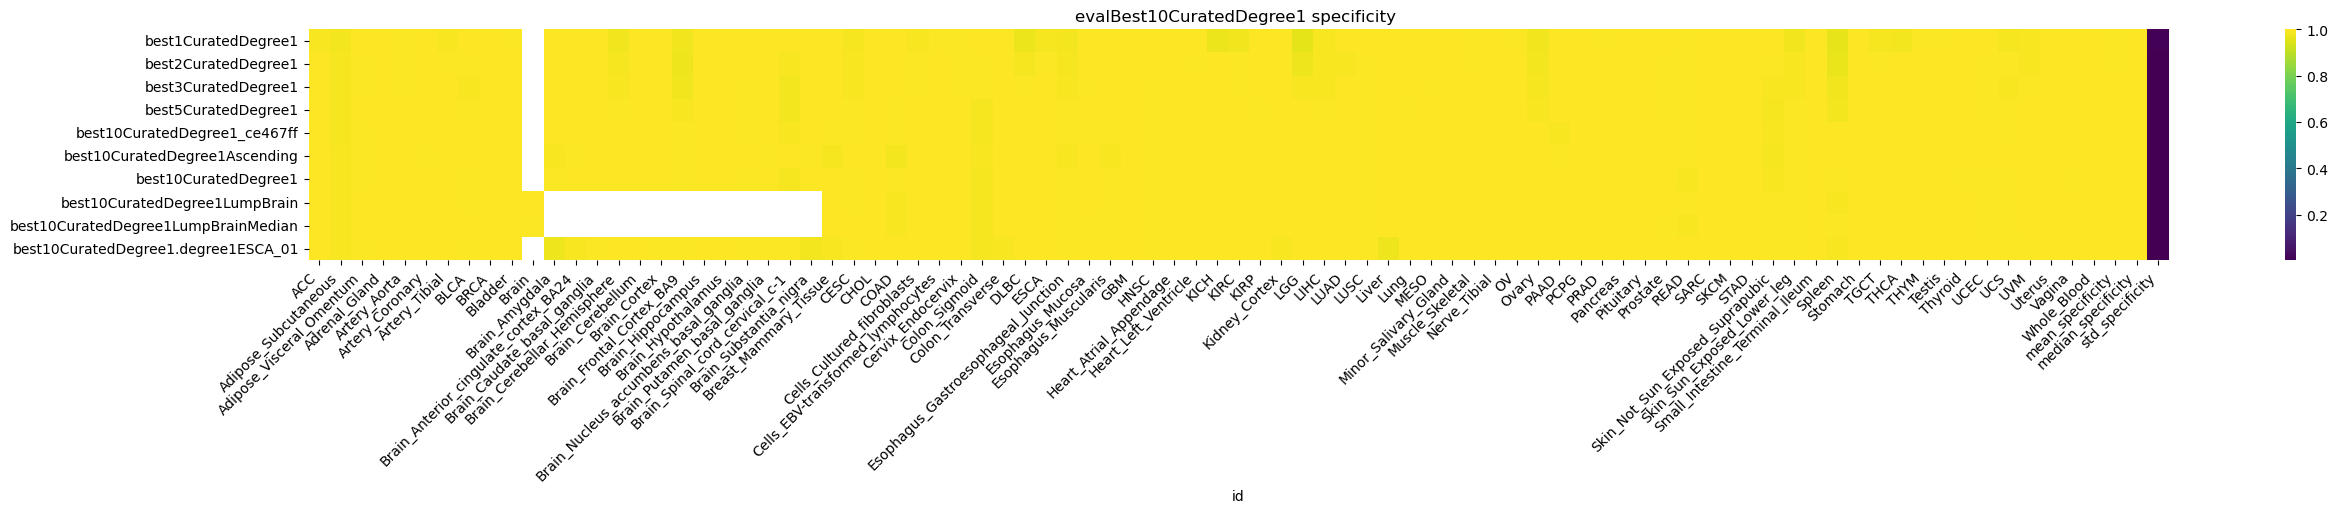

In [13]:
specifictyHeatMapDF = createHeatMapData( evalBest10CuratedDegree1SpecificityDF ) 

# Threshold does not impact heat map
# title=f'evalBest10CuratedDegree1 {evaluateBest10CuratedDegree1Metric} Threshold : {evaluateBest10CuratedDegree1SensitivityThreshold}'
title=f'evalBest10CuratedDegree1 {evaluateBest10CuratedDegree1SpecificityMetric} '
plotHeatMapSeaborn( specifictyHeatMapDF, title  )

saved image to /private/groups/kimlab/aedavids/deconvolution/1vsAll-~gender_category/hyperParameter/hyperparameterTunningResults6.out/img/evalBest10CuratedDegree1-sensitivity-.png


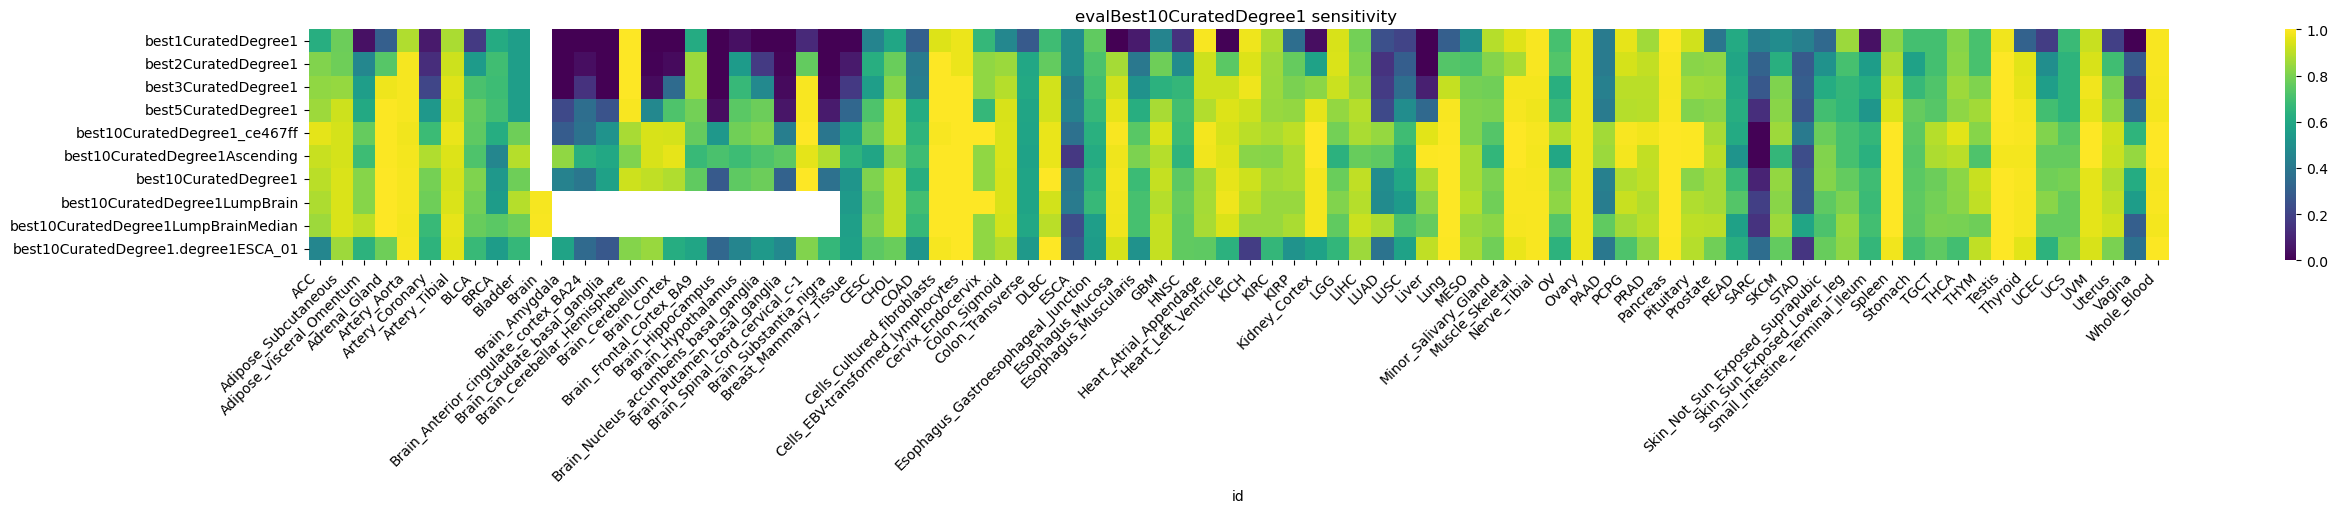

In [14]:
################################################################################

# plotHeatMapSeaborn( evalBest10CuratedDegree1SensitivityDF.loc[:,heatMapCols]  )
sensitivityHeatMapDF = createHeatMapData( evalBest10CuratedDegree1SensitivityDF ) 

# Threshold does not impact heat map
# title=f'evalBest10CuratedDegree1 {evaluateBest10CuratedDegree1Metric} Threshold : {evaluateBest10CuratedDegree1SensitivityThreshold}'
title=f'evalBest10CuratedDegree1 {evaluateBest10CuratedDegree1SensitivityMetric} '
plotHeatMapSeaborn( sensitivityHeatMapDF, title  )

## Explore under performing classes

In [15]:
def findUnderPerformaingClasses(df : pd.DataFrame, bellowThresholdDF : pd.DataFrame) -> pd.DataFrame:
    '''
    produces a dataframe that can be used sort of like a learning curve. It shows
    how each class's metric value changes between runs.
    
    returns a data frame. Index values are class names. Columns are run names.
    Data values 
        if metric value < threshold:
            the metric value
        else:
            NaN

    NaN means the class was above the threshold

    arguments are output from a function like evaluateBest10CuratedDegree1()
    example arguments
        evalBest10CuratedDegree1SensitivityDF, 
        evalBest10CuratedDegree1SensitivityBellowThresholdDF
    '''
    stageNames = bellowThresholdDF.loc[:, 'stage'].unique()

    seriesList = []
    print(f'stageNames : {stageNames}')
    for stageName in stageNames:
        #print(f'\n####### stageName : {stageName}')
        selectRows = bellowThresholdDF.loc[:, 'stage'] == stageName
        bellowCategories = bellowThresholdDF.loc[selectRows, 'category']
        bellowSeries = df.loc[stageName, bellowCategories]
        #print(f'{bellowSeries}')
        seriesList.append(bellowSeries)
       
    retDF = pd.concat( seriesList, axis=1)
    return retDF.sort_index()


def countNumberAboveThresholdDeprecated(underPerformDF : pd.DataFrame) -> pd.Series:
    '''
    counting NaN in underPeforming Dataframe is misleading. 
    - The underPerforming DF does not have all the classes. 
    - Lumping runs fewer class which inflates its NaN counts
    
    agument :
        underPerformDF, a data frame retuned by findUnderPerformaingClasses()
        
    return
        a series with id 'run name' and value = count
    '''
    tmpDF = underPerformDF.isna()
    return tmpDF.sum()

def classNamesAboveThresholdDeprecated(underPerformDF : pd.DataFrame, isBellow : bool = False) -> tuple[str,list[str]]:
    '''
    TODO

    arguments

        isBellow
            default = false.
            if True returns classes bellow threshold

    returns a list of tuples of length 2. 
        tuple[0] == run name
        tuple[1] = list of class names above the threshold class names 
    '''
    retList =  []

    tmpDF = underPerformDF.isna()
    if isBellow :
        tmpDF = ~ tmpDF
    for c in tmpDF.columns:
        booleanSeries = tmpDF.loc[:, c]
        nanNames = underPerformDF.loc[booleanSeries, c]
        #print(f'\n{c} nanNames : {nanNames.index.tolist()}')    
        retList.append( (nanNames.name, nanNames.index.tolist()) )

    return retList

In [16]:
evalBest10CD1SensUnderPerformDF = findUnderPerformaingClasses( 
                                    evalBest10CuratedDegree1SensitivityDF, 
                                    evalBest10CuratedDegree1SensitivityBellowThresholdDF )
print(f'\n############# evaluateBest10CuratedDegree1Threshold {evaluateBest10CuratedDegree1SensitivityMetric} threshold : {evaluateBest10CuratedDegree1SensitivityThreshold}')
print(f'NaN means category was above threshold or in "lumpBrain" case category is not present')
print(f'best10CuratedDegree1LumpBrain does not have any Brain* categories bellow threshold!')
print(f'evalBest10CD1SensUnderPerformDF.shape : {evalBest10CD1SensUnderPerformDF.shape}')
display( evalBest10CD1SensUnderPerformDF)

stageNames : ['best1CuratedDegree1' 'best2CuratedDegree1' 'best3CuratedDegree1'
 'best5CuratedDegree1' 'best10CuratedDegree1_ce467ff'
 'best10CuratedDegree1Ascending' 'best10CuratedDegree1'
 'best10CuratedDegree1LumpBrain' 'best10CuratedDegree1LumpBrainMedian'
 'best10CuratedDegree1.degree1ESCA_01']

############# evaluateBest10CuratedDegree1Threshold sensitivity threshold : 0.9
NaN means category was above threshold or in "lumpBrain" case category is not present
best10CuratedDegree1LumpBrain does not have any Brain* categories bellow threshold!
evalBest10CD1SensUnderPerformDF.shape : (75, 10)


,best1CuratedDegree1,best2CuratedDegree1,best3CuratedDegree1,best5CuratedDegree1,best10CuratedDegree1_ce467ff,best10CuratedDegree1Ascending,best10CuratedDegree1,best10CuratedDegree1LumpBrain,best10CuratedDegree1LumpBrainMedian,best10CuratedDegree1.degree1ESCA_01
id,,,,,,,,,,
ACC,0.625,0.812,0.833,0.854,NaN,NaN,0.896,0.875,0.854,0.458
Adipose_Subcutaneous,0.776,0.781,0.842,NaN,NaN,NaN,NaN,NaN,NaN,0.852
Adipose_Visceral_Omentum,0.043,0.462,0.557,0.603,0.763,0.686,0.818,0.818,NaN,0.643
Adrenal_Gland,0.297,0.735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.781
Artery_Aorta,0.880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Artery_Coronary,0.069,0.125,0.208,0.535,0.681,0.882,0.792,0.778,0.674,0.646
Artery_Tibial,0.874,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BLCA,0.168,0.545,0.713,0.758,0.750,0.721,0.807,0.787,0.766,0.672
BRCA,0.611,0.693,0.687,0.696,0.618,0.458,0.534,0.547,0.746,0.549


In [17]:
# countNumberAboveThreshold() is misleading. The underPerforming DF does not have all the classes. Lumping has fewer class which inflates its above count
# print(f'\n####### number of classes above threshold {evaluateBest10CuratedDegree1SensitivityThreshold}' )
# display( countNumberAboveThreshold( evalBest10CD1SensUnderPerformDF ) )

In [18]:
# print(f'\n####### {evaluateBest10CuratedDegree1Metric} classes above threshold : {evaluateBest10CuratedDegree1SensitivityThreshold} evaluateBest10CuratedDegree1 ')
# classNamesAbove = classNamesAboveThreshold(evalBest10CD1SensUnderPerformDF)
# for t in classNamesAbove:
#     print(f'\n{t[0]} nanNames : {t[1]}') 

In [19]:
# print(f'\n####### {evaluateBest10CuratedDegree1Metric} classes bellow threshold : {evaluateBest10CuratedDegree1SensitivityThreshold} evaluateBest10CuratedDegree1 ')
# classNamesBellow = classNamesAboveThreshold(evalBest10CD1SensUnderPerformDF, isBellow=True)
# for t in classNamesBellow:
#     print(f'\n{t[0]} names : {t[1]}') 

In [20]:
print(f'\n############# evaluateBest10CuratedDegree1Threshold {evaluateBest10CuratedDegree1SensitivityMetric} threshold : {evaluateBest10CuratedDegree1SensitivityThreshold}')
print(f'NaN means category was above threshold or in "lumpBrain" case category is not present')
print(f'best10CuratedDegree1LumpBrain does not have any Brain* categories bellow threshold!')
runCols = ["best10CuratedDegree1_ce467ff", "best10CuratedDegree1", "best10CuratedDegree1LumpBrain", "best10CuratedDegree1LumpBrainMedian"]
display( evalBest10CD1SensUnderPerformDF.loc[:, runCols] )


############# evaluateBest10CuratedDegree1Threshold sensitivity threshold : 0.9
NaN means category was above threshold or in "lumpBrain" case category is not present
best10CuratedDegree1LumpBrain does not have any Brain* categories bellow threshold!


,best10CuratedDegree1_ce467ff,best10CuratedDegree1,best10CuratedDegree1LumpBrain,best10CuratedDegree1LumpBrainMedian
id,,,,
ACC,NaN,0.896,0.875,0.854
Adipose_Subcutaneous,NaN,NaN,NaN,NaN
Adipose_Visceral_Omentum,0.763,0.818,0.818,NaN
Adrenal_Gland,NaN,NaN,NaN,NaN
Artery_Aorta,NaN,NaN,NaN,NaN
Artery_Coronary,0.681,0.792,0.778,0.674
Artery_Tibial,NaN,NaN,NaN,NaN
BLCA,0.750,0.807,0.787,0.766
BRCA,0.618,0.534,0.547,0.746


## Should we lump Brain samples?
There are 13 brain types. In general they have poor sensitivity

Lumping improved Brain sensitvity. How ever using present of class above sensitivity threshold lumping is not the best.
```
sensitivity                             Brain
best10CuratedDegree1LumpBrain           0.987
best10CuratedDegree1LumpBrainMedian     0.992
```

Nan means category was above threshold, or in case of 'lumpBrain' category was not present

In [21]:
brainDF = evalBest10CD1SensUnderPerformDF.loc[ evalBest10CD1SensUnderPerformDF.index.str.contains("Brain"), : ]
print(f'brainDF.shape {brainDF.shape} threshold : {evaluateBest10CuratedDegree1SensitivityThreshold}')
brainDF

brainDF.shape (13, 10) threshold : 0.9


,best1CuratedDegree1,best2CuratedDegree1,best3CuratedDegree1,best5CuratedDegree1,best10CuratedDegree1_ce467ff,best10CuratedDegree1Ascending,best10CuratedDegree1,best10CuratedDegree1LumpBrain,best10CuratedDegree1LumpBrainMedian,best10CuratedDegree1.degree1ESCA_01
id,,,,,,,,,,
Brain_Amygdala,0.000,0.000,0.000,0.220,0.286,0.835,0.440,NaN,NaN,0.582
Brain_Anterior_cingulate_cortex_BA24,0.000,0.038,0.142,0.358,0.377,0.632,0.396,NaN,NaN,0.340
Brain_Caudate_basal_ganglia,0.000,0.000,0.000,0.257,0.514,0.601,0.574,NaN,NaN,0.270
Brain_Cerebellar_Hemisphere,NaN,NaN,NaN,NaN,0.868,0.806,NaN,NaN,NaN,0.814
Brain_Cerebellum,0.000,0.007,0.028,0.465,NaN,NaN,NaN,NaN,NaN,0.847
Brain_Cortex,0.000,0.026,0.346,0.719,NaN,NaN,0.882,NaN,NaN,0.621
Brain_Frontal_Cortex_BA9,0.611,0.849,0.849,0.786,0.762,0.675,0.754,NaN,NaN,0.587
Brain_Hippocampus,0.000,0.000,0.000,0.034,0.534,0.712,0.280,NaN,NaN,0.331
Brain_Hypothalamus,0.041,0.545,0.669,0.744,0.785,0.686,0.752,NaN,NaN,0.455


# best10CuratedDegree1_ce467ff classification errors
explore symetric errors. There are error occur in similar classes for example. If the sum is high
we should consider lumping the classes

```
trueCat	                            predCat	                           errorCount errorCount_sum
Esophagus_Muscularis                Esophagus_Gastroesophageal_Junction	67	      133
Esophagus_Gastroesophageal_Junction	Esophagus_Muscularis	            66	      133
```

In [22]:
errorMetricPath = "/private/groups/kimlab/aedavids/deconvolution/1vsAll-~gender_category/best10CuratedDegree1_ce467ff/training/best10CuratedDegree1.sh.out/metrics/classificationErrors.csv"
errorMetricsDF = pd.read_csv(errorMetricPath, usecols=["trueCat", "predCat", "errorCount"])
print(f'errorMetricsDF.shape : {errorMetricsDF.shape}')
#errorMetricsDF.head()

errorMetricsDF.shape : (487, 3)


In [23]:
dropRows = errorMetricsDF.loc[:, "trueCat"] == errorMetricsDF.loc[:, "predCat"]
errorDF = errorMetricsDF.loc[~dropRows, :]
print(f'errorDF.shape : {errorDF.shape}')
# errorDF.head()

errorDF.shape : (487, 3)


In [24]:
symetricClassificaitonErrorDF, nonSymetricClassificaitonErrorDF= symetricRowSort(errorDF, "trueCat", "predCat", "errorCount")
print(f'classes we might want to lump')
print(f'symetricClassificaitonErrorDF : {symetricClassificaitonErrorDF.shape}')
symetricClassificaitonErrorDF

classes we might want to lump
symetricClassificaitonErrorDF : (108, 4)


,trueCat,predCat,errorCount,errorCount_sum
54,Skin_Not_Sun_Exposed_Suprapubic,Skin_Sun_Exposed_Lower_leg,82,198
55,Skin_Sun_Exposed_Lower_leg,Skin_Not_Sun_Exposed_Suprapubic,116,198
44,Esophagus_Muscularis,Esophagus_Gastroesophageal_Junction,67,133
45,Esophagus_Gastroesophageal_Junction,Esophagus_Muscularis,66,133
4,Colon_Sigmoid,Colon_Transverse,11,101
5,Colon_Transverse,Colon_Sigmoid,90,101
104,Adipose_Subcutaneous,Adipose_Visceral_Omentum,14,69
105,Adipose_Visceral_Omentum,Adipose_Subcutaneous,55,69
70,HNSC,LUSC,44,65
71,LUSC,HNSC,21,65


In [25]:
print(f'classification errors that are not symetric')
print(f' nonSymetricClassificaitonErrorDF.shape: {nonSymetricClassificaitonErrorDF.shape}')
nonSymetricClassificaitonErrorDF.sort_values(by="errorCount", ascending=False).head(n=10)

classification errors that are not symetric
 nonSymetricClassificaitonErrorDF.shape: (379, 3)


,trueCat,predCat,errorCount
141,Breast_Mammary_Tissue,Adipose_Subcutaneous,84
140,Brain_Substantia_nigra,Brain_Spinal_cord_cervical_c-1,44
60,BRCA,Breast_Mammary_Tissue,35
118,Brain_Hippocampus,Brain_Spinal_cord_cervical_c-1,32
430,Stomach,Colon_Sigmoid,27
46,BLCA,HNSC,25
372,SARC,Cells_Cultured_fibroblasts,25
411,STAD,PAAD,24
78,BRCA,Skin_Not_Sun_Exposed_Suprapubic,23
75,BRCA,PAAD,22


In [26]:
aedwip 5/31/24

SyntaxError: invalid syntax (3290455349.py, line 1)

In [ ]:
aedwip

In [ ]:
# 3/29 with Daniel
runOfInsterest = ["best10CuratedDegree1_ce467ff", "best10CuratedDegree1", ]
evalBest10LFCSpecificityDF.loc[ runOfInsterest ]

## which classes in best10LFC_GTEx_TCGA under performed?
<span style="color:red;background-color:yellow">aedwip: look at output of foo() looks like we could manually add genes from best10CuratedDegree1_ce467ff" </span>


In [ ]:
def foo(
    df : pd.DataFrame,
    stage : str = "best10LFC_GTEx_TCGA",
    ) -> pd.Series:
    '''
    TODO
    '''
    
    selectRows = df.loc[:,'stage'] == stage
    retSeries = df.loc[selectRows, "category"]
    return retSeries



stage = "best10LFC_GTEx_TCGA"
belowSeries = foo(evalBestLFCSensitivityBellowThresholdDF, stage)
print(f'belowSeries.shape : {belowSeries.shape}')

print('\n\n^^^^^^^^^^^^^^^')
display( evalBest10LFCSensitivityDF.loc[:, belowSeries.values] )

In [ ]:
selectBellowSenitivityRows = evalBest10LFCSensitivityDF.index == stage
display( evalBest10LFCSensitivityDF.loc[selectBellowSenitivityRows, belowSeries.values] )
aedwipDF = evalBest10LFCSensitivityDF.loc[selectBellowSenitivityRows, belowSeries.values]
aedwipDF.transpose().sort_values(by=stage)

## find difference between best10CuratedDegree1_ce467ff and best10CuratedDegree1
These two runs have the highest mean sensitivity

<span style="color:red;background-color:yellow">manual curation </span>  
look for neg difference. These are categories where best10CuratedDegree1 did better. we should be able to 
 


In [ ]:
# threshold = 0.7
metricCols = ['mean_sensitivity', 'std_sensitivity',
       'median_sensitivity', 'numGenes', 'numTypes', 'numDegree1',
       'numAboveThreshold']

categoryCols = ~ evalBest10LFCSensitivityDF.columns.isin(metricCols)

selectBestRuns = ["best10CuratedDegree1_ce467ff", "best10CuratedDegree1", ]
bestRunsDF = evalBest10LFCSensitivityDF.loc[selectBestRuns , categoryCols]
bestRunsDF.loc['diff'] = bestRunsDF.loc['best10CuratedDegree1_ce467ff', :] - bestRunsDF.loc['best10CuratedDegree1', :] #.transpose()
bestRunsDF

In [ ]:
xxxRunsDF = evalBest10LFCSensitivityDF.loc[["best10CuratedDegree1_ce467ff", "best10LFC_CuratedDegree1", ] , categoryCols]
xxxRunsDF.loc['diff'] = xxxRunsDF.loc['best10CuratedDegree1_ce467ff', :] - xxxRunsDF.loc['best10LFC_CuratedDegree1', :] #.transpose()
xxxRunsDF

# <span style="color:red;background-color:yellow">Esophagus </span>

In [ ]:
esophCategories = ['Esophagus_Gastroesophageal_Junction','Esophagus_Mucosa', 
                   'Esophagus_Muscularis', 'ESCA', 'HNSC' ]

print(f'specificity')
display( evalBest10LFCSpecificityDF.loc[:, esophCategories] )

print(f'\nsensitivity')
evalBest10LFCSensitivityDF.loc[:, esophCategories]

# <span style="color:red;background-color:yellow"> Uterus</span>

In [ ]:
uterusCategories = ['Uterus', 'UCEC', 'UCS' ]

print(f'specificity')
display( evalBest10LFCSpecificityDF.loc[:, uterusCategories] )

print(f'\nsensitivity')
evalBest10LFCSensitivityDF.loc[:, uterusCategories]

# <span style="color:red;background-color:yellow">AEDWIP </span>


In [ ]:
lungCategories = ['Lung', 'LUAD', 'LUSC']
# best10CuratedDegree1_ce467ff
# display( evalBest10LFCSpecificityDF.loc[:,  metricCols + lungCategories] )

# some where above we messed up the df

# # if we do not bind the results, jupyter lab will print them.
# evalBest10LFCSensitivityDF, evalBestLFCSensitivityBellowThresholdDF = \
#     evaluateBest10LCFResults(threshold=0.70, metric='sensitivity', verbose=False)

# display( evalBest10LFCSensitivityDF )


# evalBest10LFCSpecificityDF, evalBestLFCSpecificityBellowThresholdDF = \
#     evaluateBest10LCFResults(threshold=0.96, metric='specificity')

# display(evalBest10LFCSpecificityDF)



In [ ]:
sensitivityMetrics = ['mean_sensitivity',  
'numGenes', 'numTypes', 'numDegree1', ]

specificityMetrics = ['mean_specificity', 'numGenes', 'numTypes', 'numDegree1', ]

elifeBinaryFeatures = ['Stomach', 'Liver', 'Lung', 'COAD', 'Esophagus_Mucosa']

display(evalBest10LFCSpecificityDF.loc[["best10CuratedDegree1_ce467ff"],
                                        specificityMetrics + elifeBinaryFeatures + ['ESCA']])

display(evalBest10LFCSensitivityDF.loc[["best10CuratedDegree1_ce467ff"],
                                        sensitivityMetrics + elifeBinaryFeatures + ['ESCA']])

# aedwipDF1 = evalBest10LFCSpecificityDF.loc[ ['best10CuratedDegree1_ce467ff'], sensitivityMetrics + lungCategories]
# aedwipDF2 = evalBest10LFCSensitivityDF.loc[ ['best10CuratedDegree1_ce467ff'], specificityMetrics + lungCategories]
# # display(evalBest10LFCSpecificityDF.loc[ ['best10CuratedDegree1_ce467ff'], specificityMetrics + lungCategories])
# display(evalBest10LFCSensitivityDF.loc[ ['best10CuratedDegree1_ce467ff'], sensitivityMetrics + lungCategories])
# print(metricCols)

In [ ]:
from IPython.display import HTML
HTML(aedwipDF1.to_html(index=False))

In [ ]:
HTML(aedwipDF2.to_html(index=False))

In [ ]:
aedwipDF1.to_string(index=False)

In [ ]:
aedwipDF2.to_string(index=False)

In [ ]:
evalBest10LFCSpecificityDF.columns

In [ ]:
pd.cut(np.array([1, 7, 5, 4, 6, 3]), 2)


In [ ]:
pd.cut(np.array([1, 7, 5, 4, 6, 3]), 3, duplicates='drop')

In [ ]:
pd.cut(np.array([1, 7, 5, 4, 6, 3]), 3,retbins=True)


In [ ]:
pd.cut(np.array([1, 7, 5, 4, 6, 3]), 1)

In [ ]:
display(pd.cut(np.array([1, 7, 5, 4, 6, 3]), 2))
pd.cut(np.array([1, 7, 5, 4, 6, 3]), 2, labels=["A", "B"])

In [ ]:
pd.cut(np.array([1, 7, 5, 4, 6, 3]), 3)

In [ ]:
pd.cut(np.array([1, 7, 5, 4, 6, 3]), 4)